In [1]:
import copy
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import io
from flask import send_file

import backwardcompatibilityml.loss as bcloss
import backwardcompatibilityml.scores as scores
from backwardcompatibilityml.helpers import training
from backwardcompatibilityml.widgets import CompatibilityAnalysis

# Turn off warnings so that the widget screen
# real estate does not decrease.
import warnings
warnings.filterwarnings("ignore")

# Initialize random seed
random.seed(123)
torch.manual_seed(456)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

%matplotlib inline

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

In [3]:
dataset = list(torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('datasets/', download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))))

In [4]:
instance_ids = list(range(len(dataset)))

In [5]:
dataset_loader = []
for (instance_id, (instance_data, instance_label)) in zip(instance_ids, dataset):
    dataset_loader.append([instance_id, instance_data.view(1, 28, 28), instance_label])

In [6]:
def unnormalize(img):
    img = img / 2 + 0.5
    return img

def convert_to_image(raw_data):
    return unnormalize(np.transpose(raw_data, (1, 2, 0))).numpy()

In [7]:
def get_instance_image(instance_id):
    img_bytes = io.BytesIO()
    data = data = np.reshape(
        np.uint8(np.transpose((unnormalize(dataset_loader[instance_id][1])), (1, 2, 0)).numpy() * 255),
        (28, 28))
    img = Image.fromarray(data)
    img.save(img_bytes, format="PNG")
    img_bytes.seek(0)

    return send_file(img_bytes, mimetype='image/png')

In [8]:
training_set = dataset_loader[:int(len(dataset_loader) * 0.8)]
testing_set = dataset_loader[int(len(dataset_loader) * 0.8):]

In [9]:
train_loader = []
prev = 0
for i in range((batch_size_train - 1), len(training_set), batch_size_train):
    batch_ids = list(map(lambda r: r[0], training_set[prev:i]))
    training_data = list(map(lambda r: r[1], training_set[prev:i]))
    training_labels = list(map(lambda r: r[2], training_set[prev:i]))
    prev = i
    train_loader.append([batch_ids, torch.stack(training_data, dim=0), torch.stack(training_labels, dim=0).view(len(training_labels))])

test_loader = []
prev = 0
for i in range((batch_size_test - 1), len(testing_set), batch_size_test):
    batch_ids = list(map(lambda r: r[0], testing_set[prev:i]))
    testing_data = list(map(lambda r: r[1], testing_set[prev:i]))
    testing_labels = list(map(lambda r: r[2], testing_set[prev:i]))
    prev = i
    test_loader.append([batch_ids, torch.stack(testing_data, dim=0), torch.stack(testing_labels, dim=0).view(len(testing_labels))])

In [10]:
train_loader_a = train_loader[:int(len(train_loader)/2)]
train_loader_b = train_loader[int(len(train_loader)/2):]

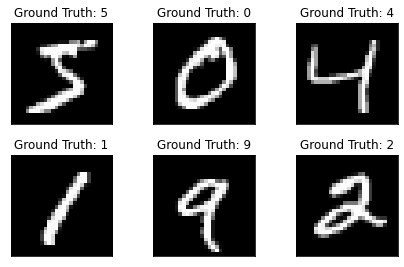

In [11]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(train_loader_a[0][1][i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(train_loader_a[0][2][i]))
    plt.xticks([])
    plt.yticks([])
fig

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x, F.softmax(x, dim=1), F.log_softmax(x, dim=1)

In [13]:
h1 = Net()
optimizer = optim.SGD(h1.parameters(), lr=learning_rate, momentum=momentum)

In [14]:
train_counter, test_counter, train_losses, test_losses = training.train(
    n_epochs, h1, optimizer, F.nll_loss, train_loader_a, test_loader,
    batch_size_train, batch_size_test)

In [15]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

Text(0, 0.5, 'negative log likelihood loss')

In [16]:
with torch.no_grad():
    _, _, output = h1(test_loader[0][1])

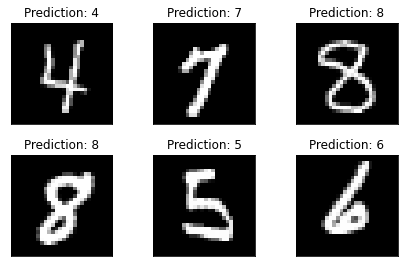

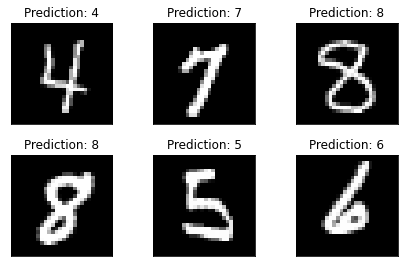

In [17]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(test_loader[0][1][i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
        output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
fig

In [18]:
# h1 = copy.deepcopy(network)

# analysis = CompatibilityAnalysis("sweeps", n_epochs, network, train_loader_b, test_loader,
#     batch_size_train, batch_size_test, learning_rate, momentum, lambda_c_stepsize=0.5)
# Here we are setting h2 to be a copy of h1 but in actuality,
# we could pass in any model as h2.
h2 = copy.deepcopy(h1)

analysis = CompatibilityAnalysis("sweeps-mnist", n_epochs, h1, h2, train_loader, test_loader,
    batch_size_train, batch_size_test,
    OptimizerClass=optim.SGD,
    optimizer_kwargs={"lr": learning_rate, "momentum": momentum},
    NewErrorLossClass=bcloss.BCKLDivergenceLoss,
    StrictImitationLossClass=bcloss.StrictImitationKLDivergenceLoss,
    new_error_loss_kwargs={"num_classes": 10},
    strict_imitation_loss_kwargs={"num_classes": 10},
    lambda_c_stepsize=0.25,
    get_instance_image_by_id=get_instance_image)